## Oracle Operators for Non-Boolean Functions

This notebook is based on the notebook "<a href="https://gitlab.com/prasanthcakewalk/code-and-data-availability/-/blob/master/arXiv_2102.04975/Non-Boolean_Oracular_Algorithms_Demo.ipynb">Non-Boolean Quantum Amplitude Amplification and Quantum Mean Estimation Demo</a>".

#### Software versions
  * Python: 3.10.4
    * qiskit: 0.35.0
      * qiskit-terra: 0.20.0
      * qiskit-aer: 0.10.3
      * qiskit-ignis: 0.7.0
      * qiskit-ibmq-provider: 0.18.3
    * numpy: 1.22.3
    * matplotlib: 3.5.1

### Imports and Software Versions

In [1]:
import qiskit
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator

## Code block to print the Python and package versions
print_versions = True
if print_versions:
    import platform
    print("Software versions")
    print(f"  * Python: {platform.python_version()}")
    print(f"    * qiskit: {qiskit.__qiskit_version__['qiskit']}")
    for key, version in qiskit.__qiskit_version__.items():
        if key != 'qiskit':
            print(f"      * {key}: {version}")
    print(f"    * numpy: {np.__version__}")
    print(f"    * matplotlib: {mpl.__version__}")

Software versions
  * Python: 3.8.5
    * qiskit: 0.25.0
      * qiskit-terra: 0.17.0
      * qiskit-aer: 0.8.0
      * qiskit-ignis: 0.6.0
      * qiskit-ibmq-provider: 0.12.2
      * qiskit-aqua: 0.9.0
    * numpy: 1.19.2
    * matplotlib: 3.3.4


### Shyamsundar's Implementation of Non-Boolean Amplitude Amplification

#### Set the Number of Qubits in the Work Register First

In [2]:
NUM_QUBITS = 4

In [3]:
##################################################################################################################
#    Title: Non-Boolean Quantum Amplitude Amplification and Quantum Mean Estimation Demo
#    Author: Prasanth Shyamsundar
#    Date: Feb 17, 2021
#    Availability: https://gitlab.com/prasanthcakewalk/code-and-data-availability/-/tree/master/arXiv_2102.04975
#
##################################################################################################################

usejournalfonts = False

if usejournalfonts: # Slow and has additional software requirements
    default_fontsize = 22
    mpl.rc('text', usetex=usejournalfonts)
    mpl.rc('text.latex', preamble=r'\usepackage[tt=false, type1=true]{libertine} \usepackage[libertine]{newtxmath}')
    
    import subprocess
    import shutil
    def compress_pdf(fname):
        tmp_fname = fname.rsplit('.', 1)[0] + "_ghostscript.pdf"
        subprocess.run(['gswin64', '-sDEVICE=pdfwrite', '-dPDFSETTINGS=/printer', '-dEmbedAllFonts=true',
                        '-dNOPAUSE', '-dQUIET', '-dBATCH', '-sOutputFile='+tmp_fname, fname])
        shutil.move(tmp_fname, fname)
else: #Faster
    default_fontsize = 18

plt.rcParams.update({'font.size': default_fontsize})

# Wrapper for circuit.draw #######################
def draw_circuit(circuit):
    mpl.rc('text', usetex=False)
    _ = circuit.draw('mpl')
    mpl.rc('text', usetex=usejournalfonts)
    return _
##################################################

# Wrapper for plt.savefig ########################
def save_figure(pltobj, fname):
    _ = pltobj.savefig(fname, bbox_inches='tight')
    if usejournalfonts:
        compress_pdf(fname)
    return _
##################################################

qasm_backend = qiskit.Aer.get_backend('qasm_simulator')

first_register = qiskit.QuantumRegister(1, name='ancilla')
second_register = qiskit.QuantumRegister(NUM_QUBITS, name='q')
output_register = qiskit.ClassicalRegister(NUM_QUBITS, name='output')

A0 = qiskit.QuantumCircuit(second_register, name=r'$A_0$')
A0.h(second_register)

A0 = A0.to_gate()

A0inv = A0.inverse()
A0inv.name = r'$A_0^\dagger$'

diffuser = qiskit.QuantumCircuit(first_register, second_register, name=r'$S_{\psi_0}$')

diffuser.h(first_register)
diffuser.append(A0inv, second_register)

diffuser.x(first_register)
diffuser.x(second_register)

diffuser.barrier()
diffuser.h(first_register)
diffuser.mct(second_register, first_register)
diffuser.h(first_register)
diffuser.barrier()

diffuser.x(first_register)
diffuser.x(second_register)

diffuser.h(first_register)
diffuser.append(A0, second_register)

diffuser.barrier()

diffuser.data = [_ for _ in diffuser.data if not isinstance(_[0], qiskit.circuit.barrier.Barrier)]
diffuser = diffuser.to_gate()

In [4]:
##################################################################################################################
#    Title: Non-Boolean Quantum Amplitude Amplification and Quantum Mean Estimation Demo
#    Author: Prasanth Shyamsundar
#    Date: Feb 17, 2021
#    Availability: https://gitlab.com/prasanthcakewalk/code-and-data-availability/-/tree/master/arXiv_2102.04975
#
##################################################################################################################

def AmplitudeAmplificationCircuit(K, f):
    circuit = qiskit.QuantumCircuit(first_register, second_register, output_register)
    
    circuit.h(first_register)
    circuit.append(A0, second_register)
    
    circuit.barrier()
    
    for k in range(K):
        circuit.x(first_register)
        circuit.append(U_f(f, NUM_QUBITS).to_gate(), [*first_register, *second_register])
        circuit.append(diffuser, [*first_register, *second_register])
        circuit.barrier()
    
    circuit.measure(second_register, output_register)
    
    return circuit

#### End of Shyamsundar's Implementation of Non-Boolean Amplitude Amplification
$\rule{20cm}{0.4pt}$

### Implementation of the Oracle Operator $\text{U}_f$

#### Implementation of $\text{R}_S$, $\text{U}_{\hat{S}\stackrel{2}{\odot}}$ and $\text{U}_S$

In [5]:
def R_S_gate(s, n = NUM_QUBITS):
    """
    This function creates a circuit for $R_S$. 
    It alters the qubits |q_n...q_2q_1> to \hat{S}\odot.
    Inputs: s: Set S as an array
            n: Total number of qubits.
    Output: Return a two-register circuit $R_S$ of n+1 qubits.
    """
    ancilla_reg = qiskit.QuantumRegister(1, name = "ancilla")
    middle_reg = qiskit.QuantumRegister(n)

    R_S = qiskit.QuantumCircuit(ancilla_reg, 
                                   middle_reg, name=r'$\hat{U}_s$')
    
    for i in range(len(s)-1):
        R_S.cx(s[i+1]+1, s[i]+1)
        
    return R_S

def U_hatS_odot_circ(s, n = NUM_QUBITS):
    """
    This function creates a circuit for $U_{\hat{S}\odot}$. 
    It alters the ancilla qubit if \hat{S}\odot x equals one.
    Inputs: s: Set S as an array
            n: Number of qubits of the basis states.
    Output: Return a two-register circuit $U_{\hat{S}\odot}$ of n+1 qubits.
    """
    ancilla_reg = qiskit.QuantumRegister(1, name = "ancilla")
    middle_reg = qiskit.QuantumRegister(n)

    U_hatS_odot = qiskit.QuantumCircuit(ancilla_reg, middle_reg, name=r'$U_{\hat{S}\odot}$')
    
    
    Uhats = R_S_gate(s, n).to_gate()
    Uhats_inv = Uhats.inverse()
    Uhats_inv.name = r'$\hat{U}_s^\dagger$'
    
    U_hatS_odot.append(Uhats_inv, [*ancilla_reg, *middle_reg])
    if s != []:
        U_hatS_odot.cx(sorted(s)[0]+1, 0)
    U_hatS_odot.append(Uhats, [*ancilla_reg, *middle_reg])
    
    return U_hatS_odot

def U_S(s, alpha, n = NUM_QUBITS):
    """
    This function creates a circuit for $U_S$. 
    It performs phase-shifts depending on the value of alpha.
    Inputs: s: Set S as an array.
            alpha: A real value. 
            n: Number of qubits of the basis states.
    Output: Return a two-register circuit $U_S$ of n+1 qubits.
    """
    ancilla_reg = qiskit.QuantumRegister(1, name = "ancilla")
    middle_reg = qiskit.QuantumRegister(n)
    
    U_s = qiskit.QuantumCircuit(ancilla_reg, middle_reg, name = r'$U_S$')
    
    U_hatS_odot_gate = U_hatS_odot_circ(s, n).to_gate()
    
    U_s.append(U_hatS_odot_gate, [*ancilla_reg, *middle_reg])
    U_s.p(-alpha, 0)
    U_s.x(0)
    U_s.p(alpha, 0)
    U_s.x(0)
    U_s.append(U_hatS_odot_gate, [*ancilla_reg, *middle_reg])
    
    return U_s

#### Implementation of Some Utilities for Binary Conversions

In [6]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    c = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    r = [list(s) for s in list(c)]
    return r

def pad(side, item, size, what = 0):
    l = len(item)
    while len(item) < size:
        if side == 'r':
            item.append(what)
        elif side == 'l':
            item.insert(0, what)
            
            
def nat2bit(x,n):
    b = bin(x)[2:]
    r = [int(b[l]) for l in range(len(b))]
    pad('l', r, n, 0)
    
    return r

def bit2nat(x, n):
    result = 0
    for i in range(len(x)):
        result += x[i] * 2**(len(x)-i-1)
        
    return result

#### Implementation of the Parity Function $\chi_S$ and the Fourier Coefficient $\hat{f}(S)$

In [7]:
def chi_S(S, x):
    """
    The characteristic function $\chi_S$.
    Inputs: S: Set S as an array, S \subset [n].
            x: an array of bitstrings.
    Outputs: -1 or 1 (i.e. (-1)^{\sum_{j \in S} x_j})
    """
    sum_x = 0
    for i in S:
        sum_x += x[i]
    
    return (-1)**sum_x

def fourier_coeff(f, S, n):
    """
    The function computes the Fourier coefficients of a real-valued
    function on the boolean cube.
    Inputs: f: a Python function implemented for a real-valued
               function on the boolean cube.
            S: Set S as an array, S \subset [n].
            n: Number of qubits.
    """
    inner_pct = 0
    for i in range(2**n):
        x = nat2bit(i, n)
        inner_pct += f(x, n)*chi_S(S, x)
        
    return (1/2**n) * inner_pct

#### Implementation of $\text{U}_f$

In [8]:
def U_f(f, n = NUM_QUBITS):
    """
    This function creates a circuit for $U_f$. 
    Inputs: f: Takes a python function, an implementation of a real-valued function.
            n: Number of qubits of the basis states.
    Output: Return an two-register circuit $U_f$ of n+1 qubits.
    """
    ancilla_reg = qiskit.QuantumRegister(1, name = "ancilla")
    middle_reg = qiskit.QuantumRegister(n)
    
    U_f = qiskit.QuantumCircuit(ancilla_reg, middle_reg, name = r'$U_f$')
    
    for s in powerset(list(range(n))):
        s_fixed = []
        max_el = n - 1
        for i in s:
            s_fixed.append(max_el - i)
            
        f_hat = fourier_coeff(f, s_fixed, n)
        U_f.append(U_S(s, f_hat, n).to_gate(), [*ancilla_reg, *middle_reg])
    
    
    return U_f

-----------------------------------------------------------

### Quadratic Unconstrained Binary Optimization (QUBO) 

#### Implementation of  
$$B(x)=\sum_{i,j =0}^{n-1} Q_{ij} x_i x_j$$ 
and 
$$b_{\pm}(x)=\pm \frac{q_{\pm} - B(x)}{||Q||_{1,1}} s$$
where $s \in [0,\frac{\pi}{2}]$ is a scaling factor

In [9]:
class Qubo:
    """
    Class for Quadratic Unconstrained Binary Optimization
    Initializes Q, q_plus, q_minus, ||Q|| and scale to pi/4
    Has setter for scale and getter for scale and Q
    Has methods B and b_m, b_p to calculate B(x), b_m(x,n), b_p(x,n)
    """
    
    def __init__(self,Q):
        self.Q = Q
        
        q_minus = 0
        for i in self.Q:
            for j in i:
                if j < 0:
                    q_minus += j
                    
        self.q_minus = q_minus
        
        q_plus = 0
        for i in self.Q:
            for j in i:
                if j > 0:
                    q_plus += j
                    
        self.q_plus = q_plus
        
        self.norm = self.q_plus - self.q_minus
        self.scale = (np.pi/4)
        
    def set_scale(self, s):
        self.scale = s
        
    def get_scale(self):
        return self.scale
    
    def get_Q(self):
        return self.Q
        
        
    def B(self, x):
        
        b = 0
        l = len(self.Q)
        
        for i in range(l):
            for j in range(l):
                b += self.Q[i,j]*x[i]*x[j]
                
        return b
    
    def b_m(self, x,n):
        return (self.B(x) - self.q_minus)*self.scale/self.norm
    
    def b_p(self, x, n):
        return (self.q_plus - self.B(x))*self.scale/self.norm

### QUBO Example
find
$$ \min / \max \bigl\{ B(x) \; \big| \; {x \in \{0, 1\}^4} \bigr\} $$
where 
$$B(x) = -5 x_3 - 3 x_2 - 8 x_1 - 6 x_0 + 4 x_3 x_2 + 8 x_3 x_1 + 2 x_2 x_1 + 10 x_2 x_0
$$
such that
$$
B(x,Q) =
\begin{pmatrix}
x_3, x_2, x_1, x_0
\end{pmatrix}
\underbrace{\begin{pmatrix}
-5	&	2	&	4	&	0	\\ 
2	&	-3	&	1	&	0 	\\ 
4	&	1	&	-8	&	5	\\ 
0	&	0	&	5	&	-6 
\end{pmatrix}}_{=Q}
\begin{pmatrix}
x_3 \\ x_2 \\ x_1 \\ x_0
\end{pmatrix}
$$

In [10]:
Q = np.array(
    [[-5, 2, 4, 0],
    [2, -3, 1, 0],
    [4, 1, -8, 5],
    [0, 0, 5, -6]])
scale = (np.pi/4)

qubo_example1 = Qubo(Q)

#### Calculation of $\theta_{-}$, $\tilde{K}_{-}$ and $\lambda_{K}(\theta_{-})$

In [11]:
##################################################################################################################
#    Title: Non-Boolean Quantum Amplitude Amplification and Quantum Mean Estimation Demo
#    Author: Prasanth Shyamsundar
#    Date: Feb 17, 2021
#    Availability: https://gitlab.com/prasanthcakewalk/code-and-data-availability/-/tree/master/arXiv_2102.04975
#
##################################################################################################################

costheta = 0
for i in range(2**NUM_QUBITS):
    x = nat2bit(i, NUM_QUBITS)
    costheta += np.cos(qubo_example1.b_m(x, NUM_QUBITS))
    
costheta /= 2**NUM_QUBITS
theta = np.arccos(costheta)
K_opt = int( np.floor(np.pi/(2*theta)) )

lambda_K = lambda K: (costheta - np.cos((2*K+1)*theta))/(np.sin(theta)**2)

print("cos(theta) =", costheta)
print("theta =", theta)
print("K_optimal =", K_opt)

for K in range(15):
    print(f"lambda_{K} = {lambda_K(K)}")

cos(theta) = 0.956357401058092
theta = 0.2965258575731768
K_optimal = 5
lambda_0 = 0.0
lambda_1 = 3.825429604232368
lambda_2 = 10.169820115310012
lambda_3 = 16.866422052977914
lambda_4 = 21.628197955941452
lambda_5 = 22.82889618587193
lambda_6 = 20.058451778908367
lambda_7 = 14.263032687414722
lambda_8 = 7.421902527403967
lambda_9 = 1.8714583401172489
lambda_10 = -0.4927005986774591
lambda_11 = 1.1368382028785107
lambda_12 = 6.203551254441702
lambda_13 = 12.97704414666625
lambda_14 = 19.144019459080816


#### Display of $K \mapsto \lambda_{K}(\theta_{-})$

Text(0, 0.5, '$\\lambda_K(\\theta_{-})$')

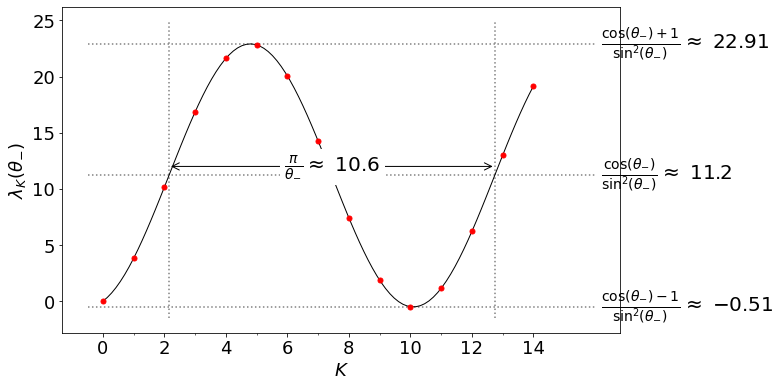

In [12]:
##################################################################################################################
#    Title: Non-Boolean Quantum Amplitude Amplification and Quantum Mean Estimation Demo
#    Author: Prasanth Shyamsundar
#    Date: Feb 17, 2021
#    Availability: https://gitlab.com/prasanthcakewalk/code-and-data-availability/-/tree/master/arXiv_2102.04975
#
##################################################################################################################

K_continuous = np.linspace(0, 14, 100)
K_discrete = np.arange(0, 15, 1)

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')

ax.plot(K_continuous, lambda_K(K_continuous), color='black', linewidth=1)
ax.plot(K_discrete, lambda_K(K_discrete), color='red', marker='o', markersize=5, linewidth=0)

ax.hlines(y=[(costheta-1)/(1-costheta**2), costheta/(1-costheta**2), (costheta+1)/(1-costheta**2)],
          xmin=-0.5, xmax=16, linestyles='dotted', colors='gray')
ax.text(16.2, costheta/(1-costheta**2), r"$\frac{\cos(\theta_{-})}{\sin^2(\theta_{-})} \approx $" + fr" ${costheta/(1-costheta**2):.3}$",
        ha='left', va='center', fontsize=default_fontsize+2)
ax.text(16.2, (costheta+1)/(1-costheta**2), r"$\frac{\cos(\theta_{-})+1}{\sin^2(\theta_{-})} \approx $" + fr" ${(costheta+1)/(1-costheta**2):.4}$",
        ha='left', va='center', fontsize=default_fontsize+2)
ax.text(16.2, (costheta-1)/(1-costheta**2), r"$\frac{\cos(\theta_{-})-1}{\sin^2(\theta_{-})} \approx $" + fr" ${(costheta-1)/(1-costheta**2):.2}$",
        ha='left', va='center', fontsize=default_fontsize+2)

ax.vlines(x=[np.pi/(4*theta) - 0.5, 5*np.pi/(4*theta) - 0.5],
          ymin=-1.5, ymax=(costheta+1)/(1-costheta**2) + 2, colors='gray', linestyles='dotted')
ax.annotate("", xy=(np.pi/(4*theta) - 0.5, 12), xytext=(5*np.pi/(4*theta) - 0.5, 12), textcoords=ax.transData, arrowprops={'arrowstyle':'<->'})
ax.text(3*np.pi/(4*theta) - 0.5, 12, r"$\frac{\,\pi\,}{\theta_{-}} \approx $" + fr" ${np.pi/theta:.3}$",
        ha="center", va="center", bbox={'color':'white'}, fontsize=default_fontsize+2)

ax.set_xticks(range(0, 15, 2))
ax.set_xticks(range(1, 15, 2), minor=True)

ax.set_xlabel(r'$K$')
ax.set_ylabel(r'$\lambda_K(\theta_{-})$')

#save_figure(plt, "lambda_minus.pdf")

#### Set Up Amplicifation Circuit for $b_{-}$

In [13]:
AACircuit_b_minus = AmplitudeAmplificationCircuit(K_opt, qubo_example1.b_m)

#### Simulate Amplitude Amplification for $b_{-}$ and Plot Probability Histogram

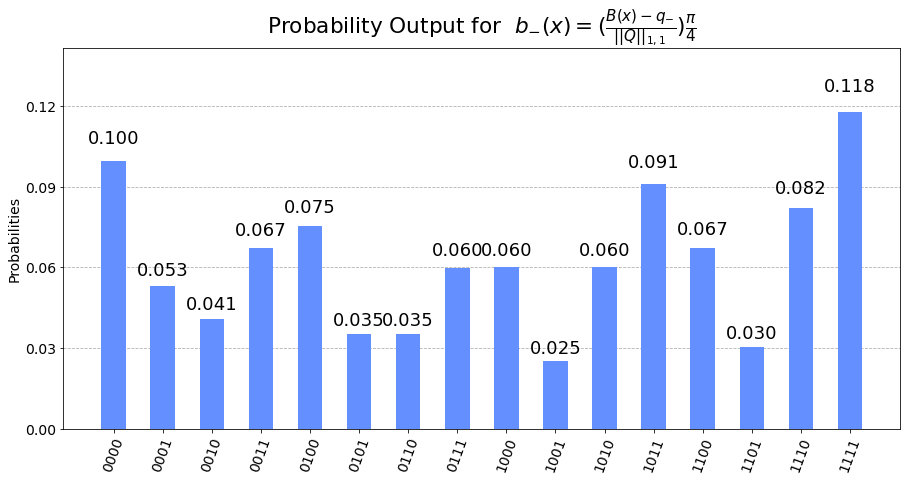

In [14]:
SHOTS = 1_000_000
SIMULATION_SEED = 0
counts_b_minus = qiskit.execute(AACircuit_b_minus, backend=qasm_backend, shots=SHOTS, seed_simulator=SIMULATION_SEED).result().get_counts()
plot_histogram(counts_b_minus, title= r"Probability Output for  $b_{-}(x) = (\frac{B(x) - q_{-}}{|| Q ||_{1,1}}) \frac{\pi}{4}$",
 figsize=(15, 7))

#### Plot $B(x)$ and the probabilities after running algorithm with $b_{-}(x)$

In [15]:
#   Prepare values of B(x) and probabilities
#
exes = []
vals = []
probs = []
for i in range(2**NUM_QUBITS):
    xlist = nat2bit(i,NUM_QUBITS)
    xstring = bin(i)[2:].zfill(NUM_QUBITS)
    exes.append(xstring)
    vals.append(qubo_example1.B(xlist))
    probs.append(counts_b_minus[xstring]/SHOTS)
    
minval = min(vals)
maxval = max(vals)
absmax = max(abs(minval), abs(maxval))
maxprob = max(probs)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


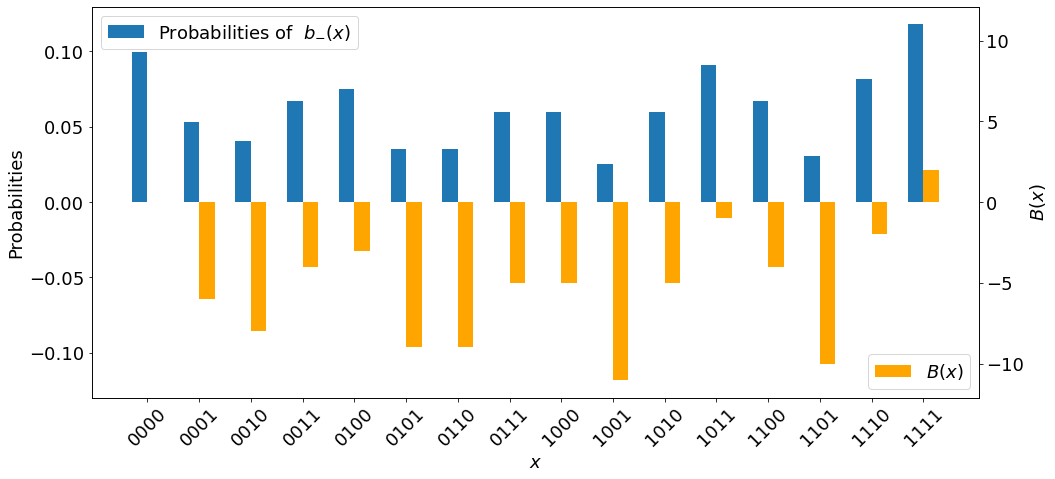

In [16]:
#   Set up plots and save to file
#
b_plus_fig, ax_probs = plt.subplots(figsize=(15,7))
width = 0.3
xticks = np.arange(len(exes))

ax_probs.bar(xticks-width/2, probs, width, label='Probabilities of  $b_{-}(x)$')
ax_probs.set_xlabel(r'$x$')
ax_probs.set_xticks(xticks)
ax_probs.set_xticklabels(exes, rotation=45)
ax_probs.set_ylabel('Probabilities')
ax_probs.set_ylim(-maxprob*1.1, maxprob*1.1)
ax_probs.legend()

ax_vals = ax_probs.twinx()
ax_vals.bar(xticks+width/2, vals, width, label=r'$B(x)$', color='orange')
ax_vals.set_ylabel(r'$B(x)$')
ax_vals.set_ylim(-absmax*1.1, absmax*1.1)
ax_vals.legend(loc='lower right')

b_plus_fig.tight_layout()
b_plus_fig.savefig('b_minus_fig.eps')
#b_plus_fig.savefig('b_minus_fig.pdf')

#### Calculation of $\theta_{+}$, $\tilde{K}_{+}$ and $\lambda_{K}(\theta_{+})$

In [17]:
##################################################################################################################
#    Title: Non-Boolean Quantum Amplitude Amplification and Quantum Mean Estimation Demo
#    Author: Prasanth Shyamsundar
#    Date: Feb 17, 2021
#    Availability: https://gitlab.com/prasanthcakewalk/code-and-data-availability/-/tree/master/arXiv_2102.04975
#
##################################################################################################################

costheta = 0
for i in range(2**NUM_QUBITS):
    x = nat2bit(i, NUM_QUBITS)
    costheta += np.cos(qubo_example1.b_p(x, NUM_QUBITS))
    
costheta /= 2**NUM_QUBITS
theta = np.arccos(costheta)
K_opt = int( np.floor(np.pi/(2*theta)) )

lambda_K = lambda K: (costheta - np.cos((2*K+1)*theta))/(np.sin(theta)**2)

print("cos(theta) =", costheta)
print("theta =", theta)
print("K_optimal =", K_opt)

for K in range(15):
    print(f"lambda_{K} = {lambda_K(K)}")

cos(theta) = 0.8782331804361097
theta = 0.49864123035971863
K_optimal = 3
lambda_0 = 0.0
lambda_1 = 3.512932721744439
lambda_2 = 7.325076245189891
lambda_3 = 7.948982852418039
lambda_4 = 4.8138866055280385
lambda_5 = 0.7878548226645745
lambda_6 = -0.4459942538865053
lambda_7 = 2.241096496326709
lambda_8 = 6.390906797221639
lambda_9 = 8.207082609491342
lambda_10 = 6.028139219120151
lambda_11 = 1.8474305246399976
lambda_12 = -0.5104227832075222
lambda_13 = 1.1116046245208933
lambda_14 = 5.2296400272171795


#### Display of $K \mapsto \lambda_{K}(\theta_{+})$

Text(0, 0.5, '$\\lambda_K(\\theta_{+})$')

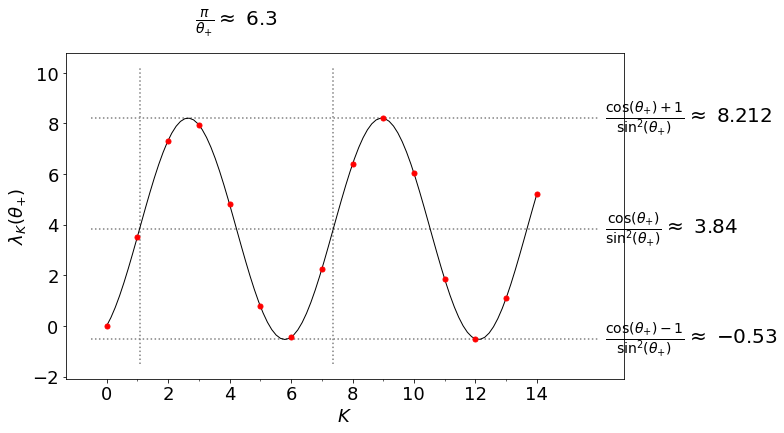

In [18]:
##################################################################################################################
#    Title: Non-Boolean Quantum Amplitude Amplification and Quantum Mean Estimation Demo
#    Author: Prasanth Shyamsundar
#    Date: Feb 17, 2021
#    Availability: https://gitlab.com/prasanthcakewalk/code-and-data-availability/-/tree/master/arXiv_2102.04975
#
##################################################################################################################

K_continuous = np.linspace(0, 14, 100)
K_discrete = np.arange(0, 15, 1)

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')

ax.plot(K_continuous, lambda_K(K_continuous), color='black', linewidth=1)
ax.plot(K_discrete, lambda_K(K_discrete), color='red', marker='o', markersize=5, linewidth=0)

ax.hlines(y=[(costheta-1)/(1-costheta**2), costheta/(1-costheta**2), (costheta+1)/(1-costheta**2)],
          xmin=-0.5, xmax=16, linestyles='dotted', colors='gray')
ax.text(16.2, costheta/(1-costheta**2), r"$\frac{\cos(\theta_{+})}{\sin^2(\theta_{+})} \approx $" + fr" ${costheta/(1-costheta**2):.3}$",
        ha='left', va='center', fontsize=default_fontsize+2)
ax.text(16.2, (costheta+1)/(1-costheta**2), r"$\frac{\cos(\theta_{+})+1}{\sin^2(\theta_{+})} \approx $" + fr" ${(costheta+1)/(1-costheta**2):.4}$",
        ha='left', va='center', fontsize=default_fontsize+2)
ax.text(16.2, (costheta-1)/(1-costheta**2), r"$\frac{\cos(\theta_{+})-1}{\sin^2(\theta_{+})} \approx $" + fr" ${(costheta-1)/(1-costheta**2):.2}$",
        ha='left', va='center', fontsize=default_fontsize+2)

ax.vlines(x=[np.pi/(4*theta) - 0.5, 5*np.pi/(4*theta) - 0.5],
          ymin=-1.5, ymax=(costheta+1)/(1-costheta**2) + 2, colors='gray', linestyles='dotted')
ax.annotate("", xy=(np.pi/(4*theta) - 0.5, 12), xytext=(5*np.pi/(4*theta) - 0.5, 12), textcoords=ax.transData, arrowprops={'arrowstyle':'<->'})
ax.text(3*np.pi/(4*theta) - 0.5, 12, r"$\frac{\,\pi\,}{\theta_{+}} \approx $" + fr" ${np.pi/theta:.3}$",
        ha="center", va="center", bbox={'color':'white'}, fontsize=default_fontsize+2)

ax.set_xticks(range(0, 15, 2))
ax.set_xticks(range(1, 15, 2), minor=True)

ax.set_xlabel(r'$K$')
ax.set_ylabel(r'$\lambda_K(\theta_{+})$')

#save_figure(plt, "lambda_plus.pdf")

#### Set Up Amplicifation Circuit for $b_{+}$

In [19]:
AACircuit_b_plus = AmplitudeAmplificationCircuit(K_opt, qubo_example1.b_p)

#### Simulate Amplitude Amplification for $b_{+}$ and Plot Probability Histogram

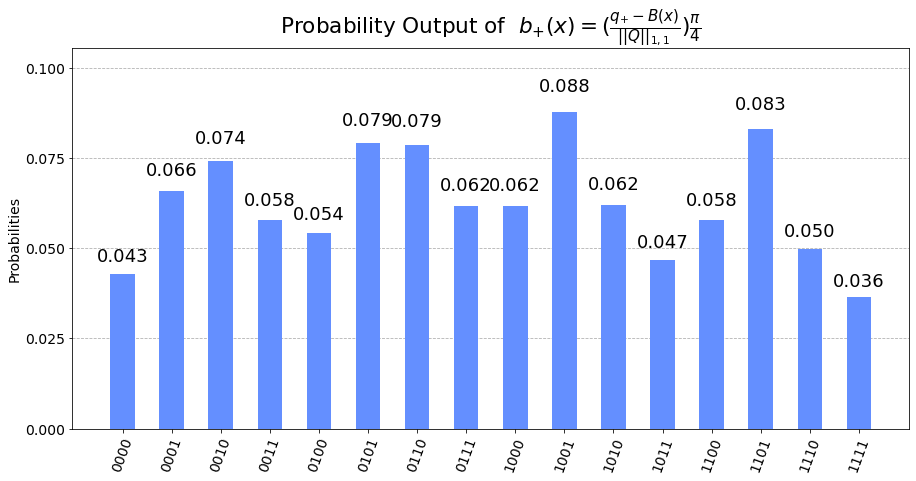

In [20]:
counts_b_plus = qiskit.execute(AACircuit_b_plus, backend=qasm_backend, shots=SHOTS, seed_simulator=SIMULATION_SEED).result().get_counts()
plot_histogram(counts_b_plus, title= r"Probability Output of  $b_{+}(x) = (\frac{q_{+} - B(x)}{|| Q ||_{1,1}}) \frac{\pi}{4}$", figsize=(15, 7))

#### Plot $B(x)$ and the probabilities after running algorithm with $b_{+}(x)$

In [21]:
#   Prepare values of B(x) and probabilities
#
exes = []
vals = []
probs = []
for i in range(2**NUM_QUBITS):
    xlist = nat2bit(i,NUM_QUBITS)
    xstring = bin(i)[2:].zfill(NUM_QUBITS)
    exes.append(xstring)
    vals.append(qubo_example1.B(xlist))
    probs.append(counts_b_plus[xstring]/SHOTS)
    
minval = min(vals)
maxval = max(vals)
absmax = max(abs(minval), abs(maxval))
maxprob = max(probs)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


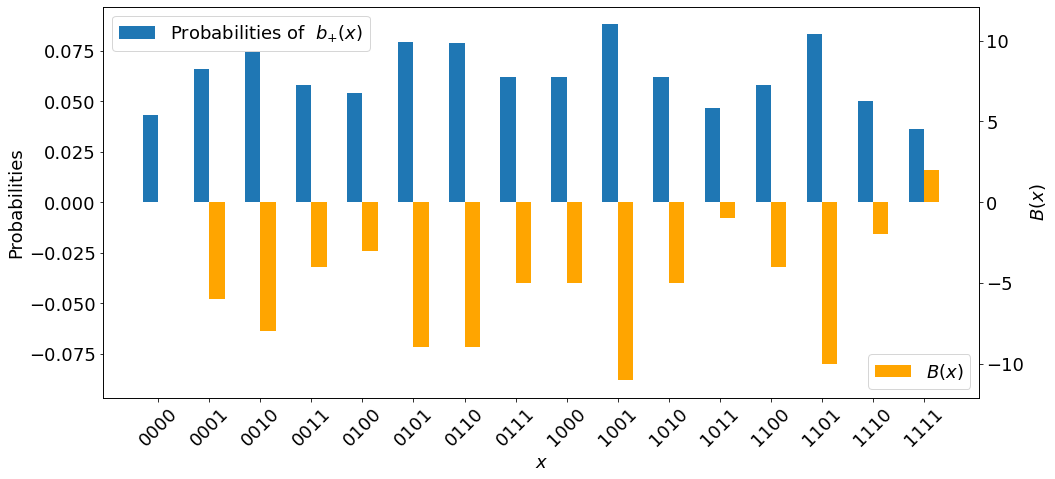

In [22]:
#   Set up plots and save to file
#
b_plus_fig, ax_probs = plt.subplots(figsize=(15,7))
width = 0.3
xticks = np.arange(len(exes))

ax_probs.bar(xticks-width/2, probs, width, label='Probabilities of  $b_{+}(x)$')
ax_probs.set_xlabel(r'$x$')
ax_probs.set_xticks(xticks)
ax_probs.set_xticklabels(exes, rotation=45)
ax_probs.set_ylabel('Probabilities')
ax_probs.set_ylim(-maxprob*1.1, maxprob*1.1)
ax_probs.legend()

ax_vals = ax_probs.twinx()
ax_vals.bar(xticks+width/2, vals, width, label=r'$B(x)$', color='orange')
ax_vals.set_ylabel(r'$B(x)$')
ax_vals.set_ylim(-absmax*1.1, absmax*1.1)
ax_vals.legend(loc='lower right')

b_plus_fig.tight_layout()
b_plus_fig.savefig('b_plus_fig.eps')
#b_plus_fig.savefig('b_plus_fig.pdf')